![MLU Logo](../data/MLU_Logo.png)

# <a name="0">Machine Learning Accelerator - Tabular Data - Lecture 3</a>


## Neural Network Model

In this notebook, we build, train, validate and test a Neural Network with PyTorch to predict the __Outcome Type__ field of our review dataset.


1. <a href="#1">Read the dataset</a>
2. <a href="#2">Exploratory Data Analysis</a>
3. <a href="#3">Select features to build the model</a>
4. <a href="#4">Training, validation, and test datasets</a>
5. <a href="#5">Data processing with Pipeline and ColumnTransformer</a>
6. <a href="#6">Neural network training and validation</a>
7. <a href="#7">Test the neural network</a>
8. <a href="#8">Improvement ideas</a>

__Austin Animal Center Dataset__:

In this exercise, we are working with pet adoption data from __Austin Animal Center__. We have two datasets that cover intake and outcome of animals. Intake data is available from [here](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm) and outcome is from [here](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238). 

In order to work with a single table, we joined the intake and outcome tables using the "Animal ID" column and created a single __review.csv__ file. We also didn't consider animals with multiple entries to the facility to keep our dataset simple. If you want to see the original datasets and the merged data with multiple entries, they are available under data/review folder: Austin_Animal_Center_Intakes.csv, Austin_Animal_Center_Outcomes.csv and Austin_Animal_Center_Intakes_Outcomes.csv.

__Dataset schema:__ 
- __Pet ID__ - Unique ID of pet
- __Outcome Type__ - State of pet at the time of recording the outcome (0 = not placed, 1 = placed). This is the field to predict.
- __Sex upon Outcome__ - Sex of pet at outcome
- __Name__ - Name of pet 
- __Found Location__ - Found location of pet before entered the center
- __Intake Type__ - Circumstances bringing the pet to the center
- __Intake Condition__ - Health condition of pet when entered the center
- __Pet Type__ - Type of pet
- __Sex upon Intake__ - Sex of pet when entered the center
- __Breed__ - Breed of pet 
- __Color__ - Color of pet 
- __Age upon Intake Days__ - Age of pet when entered the center (days)
- __Age upon Outcome Days__ - Age of pet at outcome (days)

In [1]:
%%capture
%pip install -q -r ../requirements.txt

## 1. <a name="1">Read the dataset</a>
(<a href="#0">Go to top</a>)

Let's read the dataset into a dataframe, using Pandas.

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
  
df = pd.read_csv('../data/review/review_dataset.csv')

print('The shape of the dataset is:', df.shape)

The shape of the dataset is: (95485, 13)


## 2. <a name="2">Exploratory Data Analysis</a>
(<a href="#0">Go to top</a>)

We will look at number of rows, columns and some simple statistics of the dataset.

In [3]:
# Print the first five rows
# NaN means missing data
df.head()

,Pet ID,Outcome Type,Sex upon Outcome,Name,Found Location,Intake Type,Intake Condition,Pet Type,Sex upon Intake,Breed,Color,Age upon Intake Days,Age upon Outcome Days
0,A794011,1.0,Neutered Male,Chunk,Austin (TX),Owner Surrender,Normal,Cat,Neutered Male,Domestic Shorthair Mix,Brown Tabby/White,730,730
1,A776359,1.0,Neutered Male,Gizmo,7201 Levander Loop in Austin (TX),Stray,Normal,Dog,Intact Male,Chihuahua Shorthair Mix,White/Brown,365,365
2,A674754,0.0,Intact Male,NaN,12034 Research in Austin (TX),Stray,Nursing,Cat,Intact Male,Domestic Shorthair Mix,Orange Tabby,6,6
3,A689724,1.0,Neutered Male,*Donatello,2300 Waterway Bnd in Austin (TX),Stray,Normal,Cat,Intact Male,Domestic Shorthair Mix,Black,60,60
4,A680969,1.0,Neutered Male,*Zeus,4701 Staggerbrush Rd in Austin (TX),Stray,Nursing,Cat,Intact Male,Domestic Shorthair Mix,White/Orange Tabby,7,60


In [4]:
# Let's see the data types and non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95485 entries, 0 to 95484
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Pet ID                 95485 non-null  object 
 1   Outcome Type           95485 non-null  float64
 2   Sex upon Outcome       95484 non-null  object 
 3   Name                   59138 non-null  object 
 4   Found Location         95485 non-null  object 
 5   Intake Type            95485 non-null  object 
 6   Intake Condition       95485 non-null  object 
 7   Pet Type               95485 non-null  object 
 8   Sex upon Intake        95484 non-null  object 
 9   Breed                  95485 non-null  object 
 10  Color                  95485 non-null  object 
 11  Age upon Intake Days   95485 non-null  int64  
 12  Age upon Outcome Days  95485 non-null  int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 9.5+ MB


In [5]:
# This prints basic statistics for numerical columns
df.describe()

,Outcome Type,Age upon Intake Days,Age upon Outcome Days
count,95485.000000,95485.000000,95485.000000
mean,0.564005,703.436959,717.757313
std,0.495889,1052.252197,1055.023160
min,0.000000,0.000000,0.000000
25%,0.000000,30.000000,60.000000
50%,1.000000,365.000000,365.000000
75%,1.000000,730.000000,730.000000
max,1.000000,9125.000000,9125.000000


Let's separate model features and model target. 

In [6]:
print(df.columns)

Index(['Pet ID', 'Outcome Type', 'Sex upon Outcome', 'Name', 'Found Location',
       'Intake Type', 'Intake Condition', 'Pet Type', 'Sex upon Intake',
       'Breed', 'Color', 'Age upon Intake Days', 'Age upon Outcome Days'],
      dtype='object')


In [7]:
model_features = df.columns.drop('Outcome Type')
model_target = 'Outcome Type'

print('Model features: ', model_features)
print('Model target: ', model_target)

Model features:  Index(['Pet ID', 'Sex upon Outcome', 'Name', 'Found Location', 'Intake Type',
       'Intake Condition', 'Pet Type', 'Sex upon Intake', 'Breed', 'Color',
       'Age upon Intake Days', 'Age upon Outcome Days'],
      dtype='object')
Model target:  Outcome Type


We can explore the features set further, figuring out first what features are numerical or categorical. Beware that some integer-valued features could actually be categorical features, and some categorical features could be text features. 

In [8]:
import numpy as np
numerical_features_all = df[model_features].select_dtypes(include=np.number).columns
print('Numerical columns:',numerical_features_all)

print('')

categorical_features_all = df[model_features].select_dtypes(include='object').columns
print('Categorical columns:',categorical_features_all)


Numerical columns: Index(['Age upon Intake Days', 'Age upon Outcome Days'], dtype='object')

Categorical columns: Index(['Pet ID', 'Sex upon Outcome', 'Name', 'Found Location', 'Intake Type',
       'Intake Condition', 'Pet Type', 'Sex upon Intake', 'Breed', 'Color'],
      dtype='object')


#### Target distribution

Let's check our target distribution.

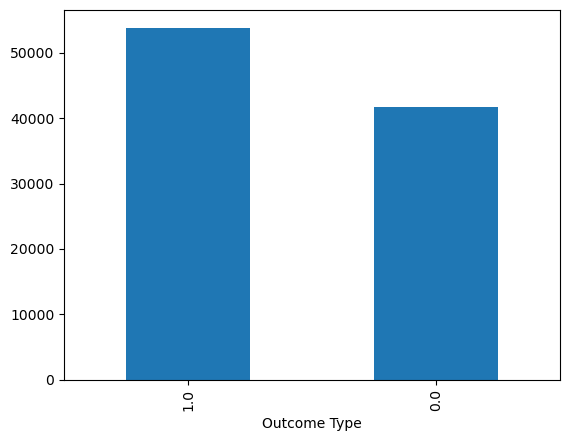

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

df[model_target].value_counts().plot.bar()
plt.show()

From the target plots we can identify whether or not we are dealing with imbalanced datasets - this means one result type is dominating the other one(s). 

Handling class imbalance is highly recommended, as the model performance can be greatly impacted. In particular the model may not work well for the infrequent classes, as there are not enough samples to learn patterns from, and so it would be hard for the classifier to identify and match those patterns. 

We might want to downsample the dominant class or upsample the rare the class, to help with learning its patterns. However, we should only fix the imbalance in training set, without changing the validation and test sets, as these should follow the original distribution. We will perform this task after train/test split. 


## 3. <a name="3">Select features to build the model</a>
(<a href="#0">Go to top</a>)

This time we build a model using all features. That is, we build a classifier including __numerical, categorical__ and __text__ features. 

In [10]:
# Grab model features/inputs and target/output

# can also grab less numerical features, as some numerical data might not be very useful
numerical_features = ['Age upon Intake Days', 'Age upon Outcome Days']

# dropping the IDs features, RescuerID and PetID here 
categorical_features = ['Sex upon Outcome', 'Intake Type',
       'Intake Condition', 'Pet Type', 'Sex upon Intake']

# from EDA, select the text features
text_features = ['Name', 'Found Location', 'Breed', 'Color']
    
model_features = numerical_features + categorical_features + text_features
model_target = 'Outcome Type'

#### Cleaning numerical features 

Age upon Intake Days


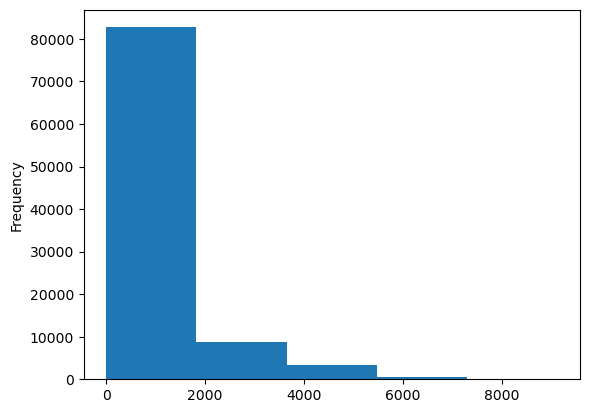

Age upon Outcome Days


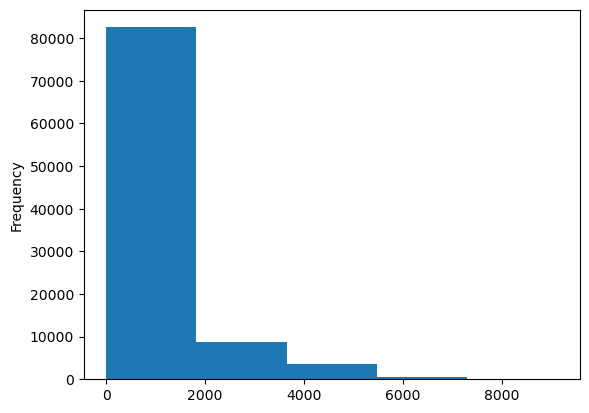

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

for c in numerical_features:
    print(c)
    df[c].plot.hist(bins=5)
    plt.show()

If for some histograms the values are heavily placed in the first bin, it is good to check for outliers, either checking the min-max values of those particular features and/or explore value ranges.

In [12]:
for c in numerical_features:
    print(c)
    print('min:', df[c].min(), 'max:', df[c].max())

Age upon Intake Days
min: 0 max: 9125
Age upon Outcome Days
min: 0 max: 9125


With __value_counts()__ function, we can increase the number of histogram bins to 10 for more bins for a more refined view of the numerical features.

In [13]:
for c in numerical_features: 
    print(c)
    print(df[c].value_counts(bins=10, sort=False))
    plt.show()

Age upon Intake Days
(-9.126, 912.5]     74835
(912.5, 1825.0]     10647
(1825.0, 2737.5]     3471
(2737.5, 3650.0]     3998
(3650.0, 4562.5]     1234
(4562.5, 5475.0]     1031
(5475.0, 6387.5]      183
(6387.5, 7300.0]       79
(7300.0, 8212.5]        5
(8212.5, 9125.0]        2
Name: count, dtype: int64
Age upon Outcome Days
(-9.126, 912.5]     74642
(912.5, 1825.0]     10699
(1825.0, 2737.5]     3465
(2737.5, 3650.0]     4080
(3650.0, 4562.5]     1263
(4562.5, 5475.0]     1061
(5475.0, 6387.5]      187
(6387.5, 7300.0]       81
(7300.0, 8212.5]        5
(8212.5, 9125.0]        2
Name: count, dtype: int64


If any outliers are identified as very likely wrong values, dropping them could improve the numerical values histograms, and later overall model performance. While a good rule of thumb is that anything not in the range of (Q1 - 1.5 IQR) and (Q3 + 1.5 IQR) is an outlier, other rules for removing 'outliers' should be considered as well. 

Let's check missing values for these numerical features.

In [14]:
print(df[numerical_features].isna().sum())

Age upon Intake Days     0
Age upon Outcome Days    0
dtype: int64


If any missing values, as a quick fix, we can apply mean imputation. This will replace the missing values with the mean value of the corresponding column.

__Note__: The statistically correct way to perform mean/mode imputation before training an ML model is to compute the column-wise means on the training data only, and then use these values to impute missing data in both the train and test sets. So, you'll need to split your dataset first. Same goes for any other transformations we would like to apply to these numerical features, such as scaling. 


#### Cleaning categorical features 

Let's also examine the categorical features.

In [15]:
for c in categorical_features:
    print(c)
    print(df[c].unique()) #value_counts())

Sex upon Outcome
['Neutered Male' 'Intact Male' 'Intact Female' 'Unknown' 'Spayed Female'
 nan]
Intake Type
['Owner Surrender' 'Stray' 'Wildlife' 'Public Assist' 'Euthanasia Request'
 'Abandoned']
Intake Condition
['Normal' 'Nursing' 'Sick' 'Injured' 'Aged' 'Feral' 'Pregnant' 'Other'
 'Behavior' 'Medical']
Pet Type
['Cat' 'Dog' 'Other' 'Bird' 'Livestock']
Sex upon Intake
['Neutered Male' 'Intact Male' 'Intact Female' 'Unknown' 'Spayed Female'
 nan]


__Note on boolean type features__: Some categories might be of boolean type, like __False__ and __True__. The booleans will raise errors when trying to encode the categoricals with sklearn encoders, none of which accept boolean types. If using pandas get_dummies to one-hot encode the categoricals, there's no need to convert the booleans. However, get_dummies is trickier to use with sklearn's Pipeline and GridSearch. 

One way to deal with the booleans is to convert them to strings, by using a mask and a map changing only the booleans. Another way to handle the booleans is to convert them to strings by changing the type of all categoricals to 'str'. This will also affect the nans, basically performing imputation of the nans with a 'nans' placeholder value! 

Applying the type conversion to both categoricals and text features, takes care of the nans in the text fields as well. In case other imputations are planned for the categoricals and/or test fields, notice that the masking shown above leaves the nans unchanged.

In [16]:
df[categorical_features + text_features] = df[categorical_features + text_features].astype('str')

Let's have a check on missing values for the categorical features (and text features here).

In [17]:
print(df[categorical_features + text_features].isna().sum())

Sex upon Outcome    0
Intake Type         0
Intake Condition    0
Pet Type            0
Sex upon Intake     0
Name                0
Found Location      0
Breed               0
Color               0
dtype: int64


Converting categoricals into useful numerical features will also have to wait until after the train/test split.

#### Cleaning text features 

Also a good idea to look at the text fields. Text cleaning can be performed here, before train/test split, with less code. 

In [18]:
for c in text_features:
    print(c)
    print(df[c].unique()) #value_counts())

Name
['Chunk' 'Gizmo' 'nan' ... '*Lingonberry' 'Guawp' '*Squanchy']
Found Location
['Austin (TX)' '7201 Levander Loop in Austin (TX)'
 '12034 Research in Austin (TX)' ... '4612 Sherwyn Drive in Austin (TX)'
 '16010 Voelker Ln in Austin (TX)' '2211 Santa Rita Street in Austin (TX)']
Breed
['Domestic Shorthair Mix' 'Chihuahua Shorthair Mix' 'Domestic Shorthair'
 ... 'Unknown' 'Bichon Frise/Lhasa Apso' 'Treeing Cur']
Color
['Brown Tabby/White' 'White/Brown' 'Orange Tabby' 'Black'
 'White/Orange Tabby' 'Blue/White' 'Brown Tabby' 'Gray' 'Calico'
 'Brown/Black' 'White/Tan' 'White' 'Brown' 'Black/White' 'Brown/White'
 'Black/Brown' 'Chocolate/White' 'Red' 'White/White' 'Brown Brindle/White'
 'Gray/Black' 'Tortie' 'Tan' 'White/Blue Tabby' 'Brown/Brown' 'Black/Gray'
 'Blue' 'Cream Tabby' 'Brown/Gray' 'Blue Tabby/White' 'Red/White'
 'Orange Tabby/White' 'Brown Merle/White' 'Tricolor' 'Apricot' 'Black/Tan'
 'Tortie Point' 'Tan/Black' 'Torbie/Brown Tabby' 'White/Black'
 'Blue Tabby' 'Blue Tick' 'W

We re-use the helper functions from the 'Text processing' notebook above.

__Warning__: cleaning stage can take a few minutes, depending on how much text is there to process.

In [19]:
# Prepare cleaning functions
import re, string
import nltk
from nltk.stem import SnowballStemmer

stop_words = ["a", "an", "the", "this", "that", "is", "it", "to", "and"]

stemmer = SnowballStemmer('english')

def preProcessText(text):
    # lowercase and strip leading/trailing white space
    text = text.lower().strip()
    
    # remove HTML tags
    text = re.compile('<.*?>').sub('', text)
    
    # remove punctuation
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    
    # remove extra white space
    text = re.sub('\s+', ' ', text)
    
    return text

def lexiconProcess(text, stop_words, stemmer):
    filtered_sentence = []
    words = text.split(" ")
    for w in words:
        if w not in stop_words:
            filtered_sentence.append(stemmer.stem(w))
    text = " ".join(filtered_sentence)
    
    return text

def cleanSentence(text, stop_words, stemmer):
    return lexiconProcess(preProcessText(text), stop_words, stemmer)

# Clean the text features
for c in text_features:
    print('Text cleaning: ', c)
    df[c] = [cleanSentence(item, stop_words, stemmer) for item in df[c].values]

Text cleaning:  Name
Text cleaning:  Found Location
Text cleaning:  Breed
Text cleaning:  Color


The cleaned text features are ready to be vectorized after the train/test split.

__Note__: more exploratory data analysis might reveal other important hidden atributes and/or relationships of the model features considered. 

## 4. <a name="4">Training, validation, and test subsets</a>
(<a href="#0">Go to top</a>)

We will split our dataset into training (80%), validation (10%), and test (10%) subsets using sklearn's [__train_test_split()__](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function twice.

In [20]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.2, shuffle=True, random_state=23)
val_data, test_data = train_test_split(test_data, test_size=0.5, shuffle=True, random_state=23)

#### Target balancing

In [21]:
print('Training set shape:', train_data.shape)

print('Class 0 samples in the training set:', sum(train_data[model_target] == 0))
print('Class 1 samples in the training set:', sum(train_data[model_target] == 1))

print('Class 0 samples in the test set:', sum(test_data[model_target] == 0))
print('Class 1 samples in the test set:', sum(test_data[model_target] == 1))

Training set shape: (76388, 13)
Class 0 samples in the training set: 33357
Class 1 samples in the training set: 43031
Class 0 samples in the test set: 4163
Class 1 samples in the test set: 5386


__Important note:__ We want to fix the imbalance only in training set. We shouldn't change the validation and test sets, as these should follow the original distribution.

In [22]:
from sklearn.utils import shuffle

class_0_no = train_data[train_data[model_target] == 0]
class_1_no = train_data[train_data[model_target] == 1]

upsampled_class_0_no = class_0_no.sample(n=len(class_1_no), replace=True, random_state=42)

train_data = pd.concat([class_1_no, upsampled_class_0_no])
train_data = shuffle(train_data)

In [23]:
print('Training set shape:', train_data.shape)

print('Class 1 samples in the training set:', sum(train_data[model_target] == 1))
print('Class 0 samples in the training set:', sum(train_data[model_target] == 0))

Training set shape: (86062, 13)
Class 1 samples in the training set: 43031
Class 0 samples in the training set: 43031


## 5. <a name="5">Data processing with Pipeline and ColumnTransformer</a>
(<a href="#0">Go to top</a>)

We can use the composite Pipeline of Day 2 to train and tune a neural network in sklearn, using its implementation of neural network __MLPClassifier__. However, sklearn is not a neural network framework, lacking access to large scale optimization techniques with GPU support and more neural network related utility functions. 
 
We instead build a neural network with __MXNet/Gluon__. While for classic, non-neural algorithms, MXNet/Gluon is not particularly useful, using an actual deep learning framework for neural network experimentation provides more flexibility and customization.

Choice of model and hosting platform aside, we can still reuse the collective ColumnTransformer from Day 2 to preprocess the data for neural network training, validation and test, ensuring that the transformations learned on the train data are performed accordingly on the training, validation and test datasets.

In [24]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


### COLUMN_TRANSFORMER ###
##########################

# Preprocess the numerical features
numerical_processor = Pipeline([
    ('num_imputer', SimpleImputer(strategy='mean')),
    ('num_scaler', MinMaxScaler()) # Shown in case is needed, not a must with Decision Trees
                                ])
                  
# Preprocess the categorical features
categorical_processor = Pipeline([
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='missing')), # Shown in case is needed, no effect here as we already imputed with 'nan' strings
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore')) # handle_unknown tells it to ignore (rather than throw an error for) any value that was not present in the initial training set.
                                ])

# Preprocess 1st text feature
text_processor_0 = Pipeline([
    ('text_vect_0', CountVectorizer(binary=True, max_features=50))
                                ])

# Preprocess 2nd text feature (larger vocabulary)
text_precessor_1 = Pipeline([
    ('text_vect_1', CountVectorizer(binary=True, max_features=150))
                                ])

# Combine all data preprocessors from above (add more, if you choose to define more!)
# For each processor/step specify: a name, the actual process, and finally the features to be processed
data_preprocessor = ColumnTransformer([
    ('numerical_pre', numerical_processor, numerical_features),
    ('categorical_pre', categorical_processor, categorical_features),
    ('text_pre_0', text_processor_0, text_features[0]),
    ('text_pre_1', text_precessor_1, text_features[1])
                                    ]) 

### DATA PREPROCESSING ###
##########################

# Get train data to train the network
X_train = train_data[model_features]
y_train = train_data[model_target]

# Get validation data to validate the network 
X_val = val_data[model_features]
y_val = val_data[model_target]

# Get test data to test the network
X_test = test_data[model_features]
y_test = test_data[model_target]

print('Datasets shapes before processing: ', X_train.shape, X_val.shape, X_test.shape)

X_train = data_preprocessor.fit_transform(X_train).toarray()
X_val = data_preprocessor.transform(X_val).toarray()
X_test = data_preprocessor.transform(X_test).toarray()

print('Datasets shapes after processing: ', X_train.shape, X_val.shape, X_test.shape)


Datasets shapes before processing:  (86062, 11) (9548, 11) (9549, 11)
Datasets shapes after processing:  (86062, 235) (9548, 235) (9549, 235)


## 6. <a name="6">Neural network training and validation</a>
(<a href="#0">Go to top</a>)

We will use PyTorch to build a simple neural network and fit to our training data. We will also use our validation data and check performance at the end of each iteration.

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Set this to CPU or GPU depending on your training instance
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set data loaders
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train.values)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val.values)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Create a simple MultiLayer Perceptron
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc3(x))
        return x

net = Net(X_train.shape[1]).to(device)

# Hyper-parameters of the system
epochs = 15
learning_rate = 0.01

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

%matplotlib inline
import matplotlib.pyplot as plt

# Training loop
for epoch in range(epochs):
    net.train()
    train_loss = 0.0
    train_predictions = []
    train_labels = []

    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(data)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        train_predictions.extend(outputs.detach().cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_loss = train_loss / len(train_loader.dataset)
    train_predictions = (np.array(train_predictions) >= 0.5).astype(int)
    train_accuracy = accuracy_score(train_labels, train_predictions)

    # Validation
    net.eval()
    val_loss = 0.0
    val_predictions = []
    val_labels = []

    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = net(data)
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item() * data.size(0)
            val_predictions.extend(outputs.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / len(val_loader.dataset)
    val_predictions = (np.array(val_predictions) >= 0.5).astype(int)
    val_accuracy = accuracy_score(val_labels, val_predictions)
    val_report = classification_report(val_labels, val_predictions)

    print(f"Epoch {epoch+1}, training loss: {train_loss:.2f}, validation loss: {val_loss:.2f}, "
          f"training accuracy: {train_accuracy:.2f}, validation accuracy: {val_accuracy:.2f}")
print("Classification report \n", val_report)

Epoch 1, training loss: 0.51, validation loss: 0.40, training accuracy: 0.76, validation accuracy: 0.83
Epoch 2, training loss: 0.41, validation loss: 0.39, training accuracy: 0.82, validation accuracy: 0.84
Epoch 3, training loss: 0.40, validation loss: 0.38, training accuracy: 0.82, validation accuracy: 0.85
Epoch 4, training loss: 0.40, validation loss: 0.38, training accuracy: 0.83, validation accuracy: 0.84
Epoch 5, training loss: 0.40, validation loss: 0.38, training accuracy: 0.83, validation accuracy: 0.84
Epoch 6, training loss: 0.39, validation loss: 0.37, training accuracy: 0.83, validation accuracy: 0.84
Epoch 7, training loss: 0.39, validation loss: 0.38, training accuracy: 0.83, validation accuracy: 0.84
Epoch 8, training loss: 0.39, validation loss: 0.37, training accuracy: 0.83, validation accuracy: 0.85
Epoch 9, training loss: 0.39, validation loss: 0.37, training accuracy: 0.83, validation accuracy: 0.85
Epoch 10, training loss: 0.39, validation loss: 0.37, training a

## 7. <a name="7">Test the neural network</a>
(<a href="#0">Go to top</a>)

Let's see how the network performs with "unseen" data (our test data).

In [26]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

net.eval()

# Predictions on train data
train_input = torch.FloatTensor(X_train).to(device)
with torch.no_grad():
    train_predictions = net(train_input).cpu().numpy()
train_predictions = (train_predictions >= 0.5).astype(int).flatten()

print(confusion_matrix(y_train, train_predictions))
print(classification_report(y_train, train_predictions))
print("Train accuracy:", accuracy_score(y_train, train_predictions))

# Predictions on test data
test_input = torch.FloatTensor(X_test).to(device)
with torch.no_grad():
    test_predictions = net(test_input).cpu().numpy()
test_predictions = (test_predictions >= 0.5).astype(int).flatten()

print(confusion_matrix(y_test, test_predictions))
print(classification_report(y_test, test_predictions))
print("Test accuracy:", accuracy_score(y_test, test_predictions))

[[32814 10217]
 [ 3572 39459]]
              precision    recall  f1-score   support

         0.0       0.90      0.76      0.83     43031
         1.0       0.79      0.92      0.85     43031

    accuracy                           0.84     86062
   macro avg       0.85      0.84      0.84     86062
weighted avg       0.85      0.84      0.84     86062

Train accuracy: 0.8397782993655737
[[3154 1009]
 [ 450 4936]]
              precision    recall  f1-score   support

         0.0       0.88      0.76      0.81      4163
         1.0       0.83      0.92      0.87      5386

    accuracy                           0.85      9549
   macro avg       0.85      0.84      0.84      9549
weighted avg       0.85      0.85      0.85      9549

Test accuracy: 0.8472091318462667


## 8. <a name="8">Improvement Ideas</a>
(<a href="#0">Go to top</a>)

* Further tune network parameters (architecture, # layers, # hidden neurons, activation functions, weights initialization, dropout, optimizer, learning rate, batch size, # epochs), while closely monitoring the loss function and the accuracy on both training and validation as a function of number of epochs.
* Experiment with different PyTorch optimizers like Adam or RMSprop.
* Implement learning rate scheduling to improve convergence.
* Use PyTorch's built-in features for early stopping and model checkpointing.
* Explore more advanced PyTorch modules like nn.Sequential for cleaner network definition.